In [1]:
from graph_tool.all import *
from numpy.random import randint
from numpy.random import random
from numpy.random import *
from IPython.display import Image #import to displaz images
from matplotlib import *
from gi.repository import Gtk, Gdk, GdkPixbuf, GObject, GLib
import sys, os, os.path
import time
import numpy as np
import matplotlib.pyplot as plt
#things to be done, figure out all the movement and movement in between states
#add different infection probabilities for vaccination and age group
#if person is vaccinated and not vaccinated


In [2]:
#PRE:  g is graph, distribution is string with country name. distribution must be for 20 age groups, normalized to
#      number of vertices in graph g
#POST: assigns age property randomly to the vertices in g, according to distribution

def add_ages(g,distribution):
    path1 = 'Age_Dists/'
    path2 = 'Dist.csv'
    #generate array containing amount of people per age group
    agedistribution = np.genfromtxt(path1+distribution+path2, delimiter=',')[:,1]
    #visit vertices in random order
    
    vs = list(g.vertices())
    shuffle(vs)
    #we will fill all age groups one by one
    a = 1 #current agegroup
    counter = 0 #counter for how many people have been placed in current group
    
    for v in vs:
        if(a > 20):
            #safety measure
            return
        if counter < agedistribution[a-1]:
            #if current age group hasn't gotten enough people assigned, add another, move on to next vertix
            age[v] = a
            agegrouplists[a-1].append(v)
            counter = counter + 1
        else:
            #current age group is full, move to next age group with at least one person
            a = a + 1
            while(agedistribution[a-1] == 0):
                if(a < 20):
                    a = a + 1
                else:
                    #in case number for last age group is 0
                    return
            age[v] = a
            agegrouplists[a-1].append(v)
            counter = 1

In [11]:
def update_state():
    global sval
    global ival
    global rval
    global vval
    global dval
    global scount
    global icount
    global vcount
    global rcount
    global dcount
    global ccount
    global tlist
    
    global tags
    global tag
    
    newly_infected.a = False

    removed.a = False
    
    if ccount==20:
        plt.plot(tlist, sval, label = "S")
        plt.plot(tlist, rval, label = "R")
        plt.plot(tlist, vval, label = "V")
        plt.plot(tlist, ival, label = "I")
        plt.plot(tlist, dval, label = "D")
        plt.legend()
        plt.show()
        
        
    # visit the nodes in random order
    ccount+=1

    vs = list(g.vertices())

    shuffle(vs)

    for v in vs:

        if state[v] == I: #infected
            
            if vac[v]==False and random() < reclist[age[v]-1] : #r: recovery rate
                rcount+=1
                icount-=1
                tag = 'a'
                state[v] = R
                
            elif vac[v] == True and random() < vac_reclist[age[v]-1]:
                rcount+=1
                icount-=1
                tag = 'b'
                state[v] = R
                
            elif vac[v] == False and random() < drlist[age[v]-1]:
                state[v] = D       #dead
                dcount+=1
                icount-=1
                tag = 'c'
                g.clear_vertex(v)  # red circle with no adjacent edges
                
            elif vac[v] == True and random() < vac_drlist[age[v]-1]:
            
                state[v] = D       #vac dead
                dcount+=1
                icount-=1
                tag = 'd'
                g.clear_vertex(v)  # red circle with no adjacent edges

        elif state[v] == S:

            if random() < vacc_av[age[v]-1]*vacc_ac[age[v]-1]:
                
                state[v] = V #if vaccine is available and accepted by individual, vaccinate
                vac[v] = True
                vcount+=1
                scount-=1
            
            else: 
                ns = list(v.out_neighbors())
                
                i = 0

                for w in ns: #iterate through all neighbors, each has infection probability

                    if state[w] == I and random()<inflist[age[v]-1]:

                        #infection rate dependent on age
                        i = 1 
                if i:#if infected by at least one neighbor, change status
                    state[v] = I
                    icount+=1
                    tag = 'z'
                    scount-=1
                    newly_infected[v] = True
    
        elif state[v] == V:
            
            ns = list(v.out_neighbors())

            if len(ns) > 0:

                w = ns[randint(0, len(ns))]  # choose a random neighbor

                if state[w] == I:

                    #infection rate dependent on age
                    if random()<vac_inflist[age[v]]:
                            icount+=1
                            tag = 'zz'
                            vcount-=1
                            state[v] = I

                            newly_infected[v] = True
                        

        if state[v] == R:
        
            removed[v] = True
       
    ival.append(icount)
    vval.append(vcount)
    sval.append(scount)
    rval.append(rcount)
    dval.append(dcount)
    tags.append(str(ccount)+tag)
    

    # Filter out the recovered vertices

    g.set_vertex_filter(removed, inverted=True)


    # The following will force the re-drawing of the graph, and issue a

    # re-drawing of the GTK window.

    win.graph.regenerate_surface()
    time.sleep(0.2)
    win.graph.queue_draw()


    # if doing an offscreen animation, dump frame to disk

    if offscreen:

        global count

        pixbuf = win.get_pixbuf()

        pixbuf.savev(r'./frames/sirs%06d.png' % count, 'png', [], [])

        if count > max_count:

            sys.exit(0)

        count += 1


    # We need to return True so that the main loop will call this function more

    # than once.

    return True


In [14]:
# SET UP GRAPH

size = 100

g = Graph(directed=False)

#definition of vertex properties
S = [1, 1, 1, 1]           # White color

I = [0, 0, 0, 1]           # Black color

R = [0.5, 0.5, 0.5, 1.]    # Grey color (will not actually be drawn)

V = [0, 0, 1, 1]           # Blue color

D = [0.8, 0, 0, 0.6]       #DEATH (red)

tlist = list()

for i in range(20):
    tlist.append(i+1)
    
sval=list()

ival=list()
rval=list()
vval=list()
dval=list()
scount=0
icount=0
vcount=0
rcount=0
dcount=0
ccount=0
tags = list()

#all definitions of vertice edges
state = g.new_vertex_property("vector<double>")
age=g.new_vertex_property("int")
vac=g.new_vertex_property("bool")
removed = g.new_vertex_property("bool")
newly_infected = g.new_vertex_property("bool")


agegroups=20
agegrouplists = [[] for i in range(1, agegroups+1)]

#probabilities


#death probability list for different age groups: https://pubmed.ncbi.nlm.nih.gov/32674819/
drlist = [.003,.003,.003,.003,.003,.003,.005,.005,.011,.011,.03,.03,.095,.095,.228,.228,.296,.296,.296,0.296]
#same VACCINATED
vac_drlist = [.001,.001,.001,.001,.001,.001,.002,.002,.005,0.005,0.015,0.015,.047,.047,.114,.114,.148,.148,.148,.148]


#vaccine availability by age group:
vacc_av = [0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
#vaccine acceptance rate by age group:
vacc_ac = [0,0,0,0,0.5,0.5,0.5,0.5,0.6,0.6,0.6,0.6,0.7,0.7,0.7,0.7,0.8,0.8,0.9,0.9]

#infection probability for different age groups
inflist = [0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
#same VACCINATED
vac_inflist = [.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,.20,0.20]

#recovery probability for different age groups
reclist = [0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.32,0.32,0.28,0.28,0.22,0.22,0.15,0.15,0.10,0.10,0.08,0.08]
#same VACCINATED
vac_reclist = [0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.35,0.35,0.31,0.31,0.26,0.26,0.20,0.20,0.14,0.14,0.13,0.13]

# insert random vertices (nodes)
g.add_vertex(size)

# insert some random links
for s,t in zip(randint(0, size, 2*size), randint(0, size, 2*size)):
    g.add_edge(g.vertex(s), g.vertex(t))
# layout positions
pos = sfdp_layout(g)
global scount
global vcount
#makes all nodes suceptible
for i in g.vertices():
    v = g.vertex(i) 
    
    state[v] = S
    scount+=1
    vac[v]=False;
    
    '''if random() < vac_prob:
    
        vac[v]=True;
        vcount+=1
        scount-=1
        state[v] = V'''

#this line is to randomlyinitialize one vertex as infected
state[randint(0,size)]= I

#assign ages to vertices following given age distribution
add_ages(g,'Japan')

In [15]:
#DISPLAY SETTINGS

#Displaying how the graph will be initialized
graph_draw(g, vertex_text=g.vertex_index, output="two-nodes.png")
fig = Image(filename=('two-nodes.png'))
fig


# If True, the frames will be dumped to disk as images.
# CAN SOMONE FIGURE OUT WHAT THIS DOES???????????????????????????????
#if the argument passed from command line=="offscreen" then do the thing else false

offscreen = sys.argv[1] == "offscreen" if len(sys.argv) > 1 else False

max_count = 500

if offscreen and not os.path.exists("./frames"):

    os.mkdir("./frames")
#?????????????????????????????????????????????????????????????????????


# This creates a GTK+ window with the initial graph layout,basically creates the pop up window

if not offscreen:

    win = GraphWindow(g, pos, geometry=(500, 400),
                      

                      edge_color=[0.6, 0.6, 0.6, 1],

                      vertex_fill_color=state,

                      vertex_halo=newly_infected,

                      vertex_halo_color=[0.8, 0, 0, 0.6],)

else:

    count = 0

    win = Gtk.OffscreenWindow()

    win.set_default_size(500, 400)

    win.graph = GraphWidget(g, pos,
                            
                            edge_color=[0.6, 0.6, 0.6, 1],

                            vertex_fill_color=state,
                            
                            vertex_halo=newly_infected,

                            vertex_halo_color=[0.8, 0, 0, 0.6])

    win.add(win.graph)

In [7]:
for i in range(1,agegroups+1):
    print(i,': ',len(agegrouplists[i-1]))

1 :  4
2 :  4
3 :  4
4 :  4
5 :  5
6 :  5
7 :  5
8 :  6
9 :  7
10 :  8
11 :  7
12 :  6
13 :  6
14 :  6
15 :  7
16 :  6
17 :  4
18 :  3
19 :  2
20 :  0


In [8]:
#drlist[age[10]]

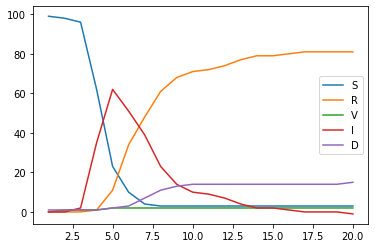

In [16]:
cid = GLib.idle_add(update_state)


# We will give the user the ability to stop the program by closing the window.

win.connect("delete_event", Gtk.main_quit)


# Actually show the window, and start the main loop.

win.show_all()

Gtk.main()

In [ ]:
print(tags)

In [ ]:
g.list_properties()

In [ ]:
g.save("my_graph.xml.gz")
g2 = load_graph("my_graph.xml.gz")